In [1]:
import numpy as np
from numpy import pi
from scipy import sparse as sp
from scipy.sparse import linalg as linalg
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from copy import copy

In [2]:
%matplotlib notebook

## Simulation Parameters

In [3]:
# Planck's constant is set to 1

# Mass of the particle
mass = 0.5

# Time-related parameters
final_time = 5
time_steps = 5000
dt = final_time / time_steps

# Space/mesh related parameters
xi = -20 # Left endpont
xf = +20 # Right endpoint
mesh_size = 3001
dx = (xf-xi) / (mesh_size-1)

## Setting up the potential

In [4]:
# Our potential function
def V(x):
    return 8  if 2 <= x <= 6  else  0

# Store the potential in a grid
potential = np.array([V(xi + i*dx) for i in range(mesh_size)])

In [5]:
# Define the X grid and the Psi array
Xgrid = np.linspace(xi, xf, mesh_size)
Psi = np.zeros((time_steps, mesh_size), complex)

## Parameters for the Initial Distribution

In [6]:
# we need to specify the intial Psi values
k0 = 3 #wave number
sigma0 = 1 #the standard deviation of the initial Gaussian
mu0 = -9 #where the initial Gaussian is centered
Psi[0,:] = (1/(2*pi*sigma0**2)**(1/4)) * np.exp((1j)*k0*Xgrid - ((Xgrid-mu0)/(2*sigma0))**2)

## Setting up the Absorbing Boundary Conditions

In [7]:
# setting up the ABC's
q = k0/mass
h1 = 3*mass*q
h2 = 3*(mass**2)*(q**2)
h3 = (mass**3)*(q**3)

ai = h2/(2*mass) - V(xi)
af = h2/(2*mass) - V(xf)
bi = h3/(2*mass) - h1*V(xi)
bf = h3/(2*mass) - h1*V(xf)

beta1 = -(1j)*ai/(2*dx) + 1/(dt*dx) - (1j)*h1/(2*dt) - bi/4
beta2 = (1j)*ai/(2*dx) - 1/(dt*dx) - (1j)*h1/(2*dt) - bi/4
beta3 = (1j)*ai/(2*dx) + 1/(dt*dx) - (1j)*h1/(2*dt) + bi/4
beta4 = -(1j)*ai/(2*dx) - 1/(dt*dx) - (1j)*h1/(2*dt) + bi/4

zeta1 = -(1j)*af/(2*dx) + 1/(dt*dx) - (1j)*h1/(2*dt) - bf/4
zeta2 = (1j)*af/(2*dx) - 1/(dt*dx) - (1j)*h1/(2*dt) - bf/4
zeta3 = (1j)*af/(2*dx) + 1/(dt*dx) - (1j)*h1/(2*dt) + bf/4
zeta4 = -(1j)*af/(2*dx) - 1/(dt*dx) - (1j)*h1/(2*dt) + bf/4

## Preparing to Solve for Psi

In [8]:
# setting up the tridiagonal matrices
ones = np.ones((mesh_size), complex)
alpha = (1j)*dt/(2*dx**2)
xis = np.array([2*mass + (1j)*dt/(dx**2) + (1j)*mass*dt*potential[i] for i in range(mesh_size)])
xis[0] = beta1
xis[mesh_size-1] = zeta1
up = -alpha*ones
up[1] = beta2
down = -alpha*ones
down[mesh_size-2] = zeta2
gamma = np.array([2*mass - (1j)*dt/(dx**2) - (1j)*mass*dt*potential[i] for i in range(mesh_size)])
gamma[0] = beta3
gamma[mesh_size-1] = zeta3
ups = alpha*ones
ups[1] = beta4
downs = alpha*ones
downs[mesh_size-2] = zeta4

In [9]:
diags = np.array([-1, 0, 1])
vecs1 = np.array([down, xis, up])
vecs2 = np.array([downs, gamma, ups])

U1 = sp.spdiags(vecs1, diags, mesh_size, mesh_size)
U1 = U1.tocsc()
U2 = sp.spdiags(vecs2, diags, mesh_size, mesh_size)

## Solving for Psi

In [10]:
LU = linalg.splu(U1)
for i in range(time_steps - 1):
    b = U2.dot(Psi[i,:])
    Psi[i+1,:] = LU.solve(b)

In [11]:
# Compute probability density
Density = np.abs(Psi * np.conj(Psi))

## View the animation

<IPython.core.display.Javascript object>


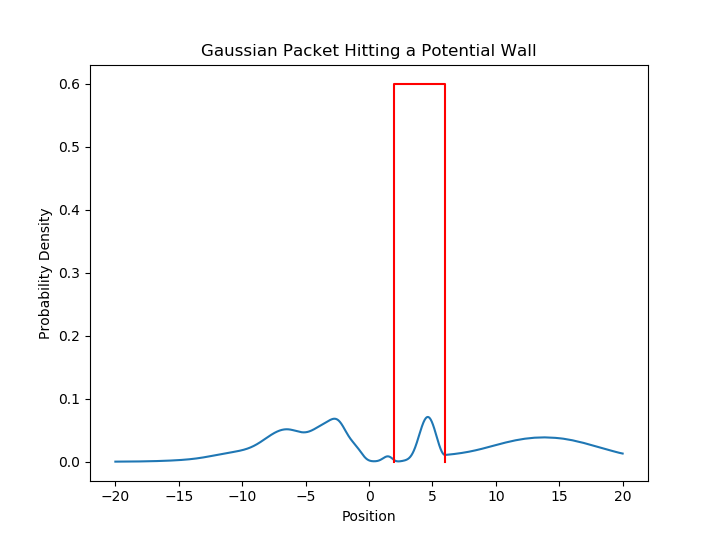

In [24]:
fig, ax = plt.subplots(figsize=(7.2, 5.4))
line, = ax.plot(Xgrid, Density[0,:])

# Graph the potential
ax.plot([2, 2, 6, 6], [0, 0.6, 0.6, 0], color='red')


def animate(i):   
    line.set_ydata(Density[i,:])  # update the data
    return line,

# Init only required for blitting to give a clean slate.
def init():
    line.set_ydata(np.ma.array(Xgrid, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(0, time_steps, 1), init_func=init,
                              interval=1, blit=True)

plt.title('Gaussian Packet Hitting a Potential Wall')
plt.xlabel('Position')
plt.ylabel('Probability Density')

FFMpegWriter = animation.writers['ffmpeg']
writer = FFMpegWriter(fps=60)
#ani.save('presentation/barrier.mp4', writer=writer)

plt.show()

### Utility method to compute derivatives

In [13]:
# we need a little subroutine to compute derivatives
# dim carries the dimension along which we will differentiate
def derivative(array, dim, dd):
    leng = array.shape[dim]
    der = np.zeros_like(array)
    for i in range(1, leng-1):
        indxl = [Ellipsis]*array.ndim
        indx = [Ellipsis]*array.ndim
        indxr = [Ellipsis]*array.ndim
        indxl[dim] = i-1
        indx[dim] = i
        indxr[dim] = i+1
        der[indx] = (array[indxr]-array[indxl])/(2*dd)
    indx0 = [Ellipsis]*array.ndim
    indx1 = [Ellipsis]*array.ndim
    indx0[dim] = 0
    indx1[dim] = 1
    der[indx0] = (array[indx1]-array[indx0])/dd
    indxm1 = [Ellipsis]*array.ndim
    indxm2 = [Ellipsis]*array.ndim
    indxm1[dim] = -1
    indxm2[dim] = -2
    der[indxm1] = (array[indxm1]-array[indxm2])/dd
    
    return der

## Displaying the Quantum Potential

In [14]:
DisplayQuantumPotential = False
if DisplayQuantumPotential:

    # let see if we can plot the quantum potential
    R = np.sqrt(Density)
    Rn = copy(R)
    Rn[Rn < 0.001] = 1
    
    # Compute the quantum potential
    Q = -1/(2*mass)*derivative(derivative(R, 1, dx), 1, dx)/Rn
    figa, axa = plt.subplots()
    plt.axis([xi, xf, -40, 20])
    lina, = axa.plot(Xgrid, Q[0,:])

    def animata(i):   
        lina.set_ydata(Q[i,:])  # update the data
        return lina,

    # Init only required for blitting to give a clean slate.
    def inita():
        lina.set_ydata(np.ma.array(Xgrid, mask=True))
        return lina,

    ana = animation.FuncAnimation(figa, animata, np.arange(0, N), init_func=inita,
                                  interval=1, blit=True)
    plt.show()

## Computing the action function

In [15]:
# Now lets compute the trajectories
S = np.angle(Psi)
for i in range(time_steps):
    S[i,:] = np.unwrap(S[i,:])

In [16]:
DisplayActionFunction = False
if DisplayActionFunction:
    figb, axb = plt.subplots()
    plt.axis([xi, xf, -100, 100])
    lineb, = axb.plot(Xgrid, S[0,:])

    def animateb(i):   
        lineb.set_ydata(S[i,:])  # update the data
        return line,

    # Init only required for blitting to give a clean slate.
    def init():
        lineb.set_ydata(np.ma.array(Xgrid, mask=True))
        return line,

    ani = animation.FuncAnimation(figb, animateb, np.arange(0, time_steps, 10), init_func=init,
                                  interval=1, blit=True)
    plt.show()

## Extracting the velocity field

In [17]:
v = derivative(S, 1, mass*dx)

C:\Users\Totom3\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
C:\Users\Totom3\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\Totom3\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will resul

## Computing the trajectories

In [18]:
nt = 1000 #this is how many trajectories will be computed
x = np.zeros((nt, time_steps))
x[:,0] = np.linspace(mu0 - 3*sigma0, mu0 + 3*sigma0, nt)

for l in range(nt):
    # Compute the location of the particle
    for i in range(1,time_steps):
        # The grid index location
        loca = (x[l,i-1] - xi)/dx 
        k = np.int(np.floor(loca))
        # Check if the particle reached the right end
        if k > mesh_size-2:
            x[l, i:time_steps] = xf
            
        # Check if the particle reached the left end
        elif k < 0:
            x[l, i:time_steps] = xi
            
        # Interpolate the position
        else:
            x[l,i] = x[l,i-1] + (v[i-1,k]*(loca-k)+v[i-1,k+1]*(1-loca+k))*dt

# Transpose X for ease of use
x = np.transpose(x)

## Displaying the trajectories

<IPython.core.display.Javascript object>


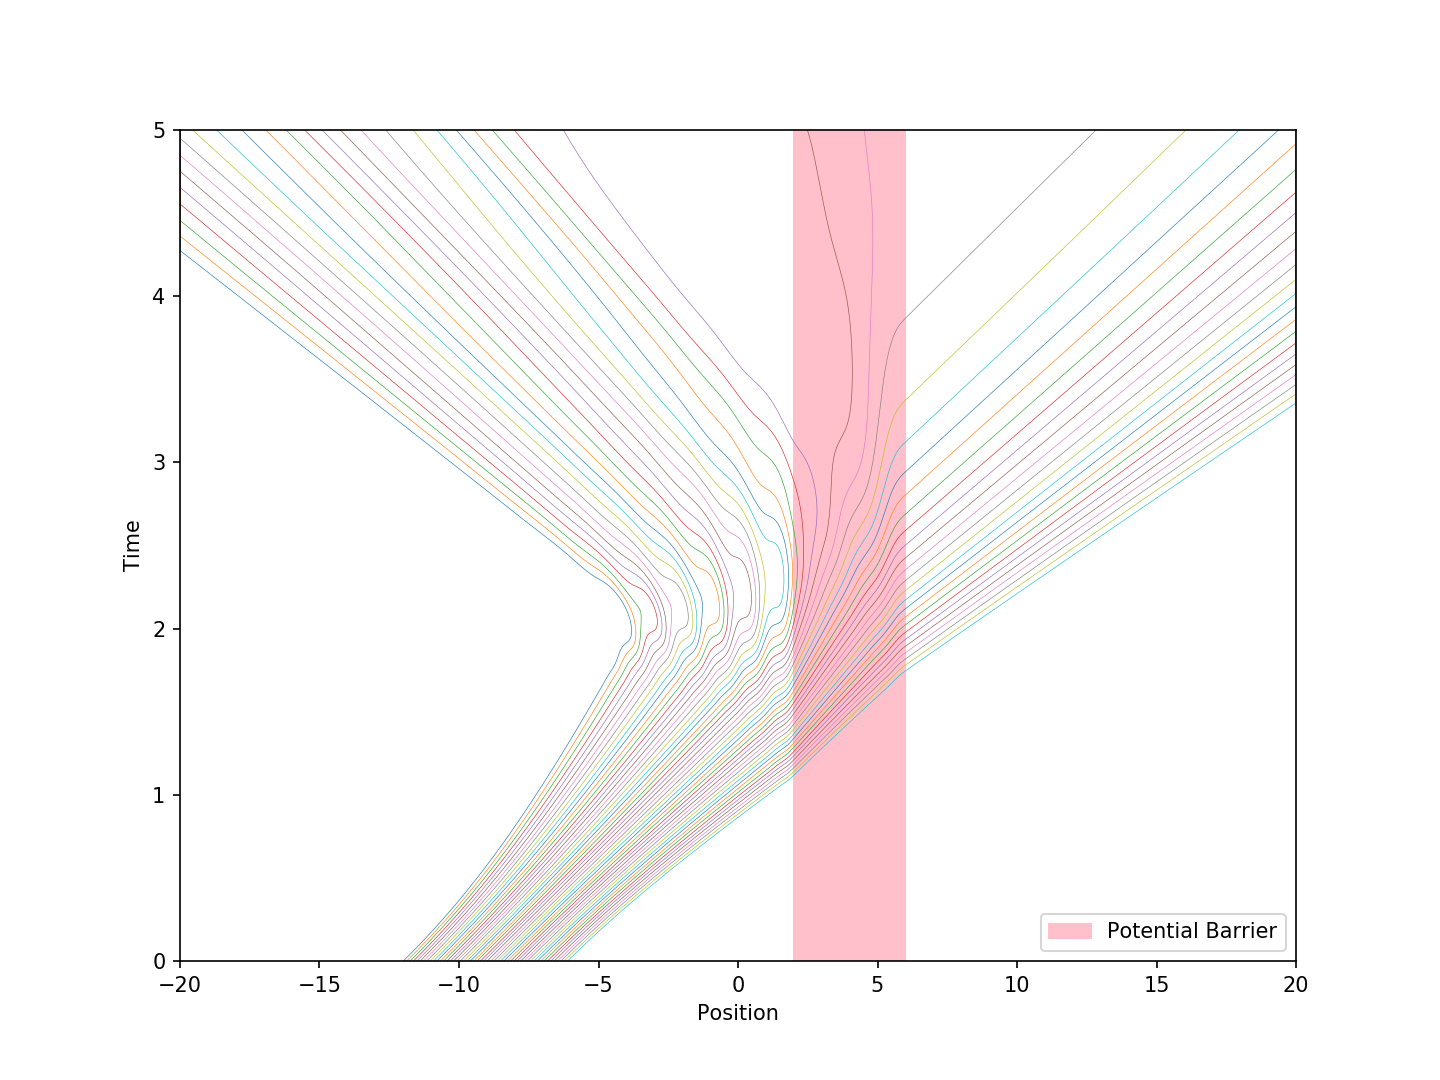

In [19]:
Tgrid = np.linspace(0, time_steps*dt, time_steps)
skip = 20

plt.figure(figsize=(9.6, 7.2))
plt.axis([xi, xf, 0, time_steps*dt])
for l in range(nt//skip):
    plt.plot(x[:, l*skip],Tgrid, linewidth=0.3)

rect = plt.Rectangle((2,0),4,5,linewidth=1,edgecolor='pink',facecolor='pink', label='Potential Barrier')
plt.gca().add_patch(rect)

plt.xlabel('Position')
plt.ylabel('Time')
plt.legend()
plt.show()

plt.savefig('presentation/trajectories.png')


<IPython.core.display.Javascript object>


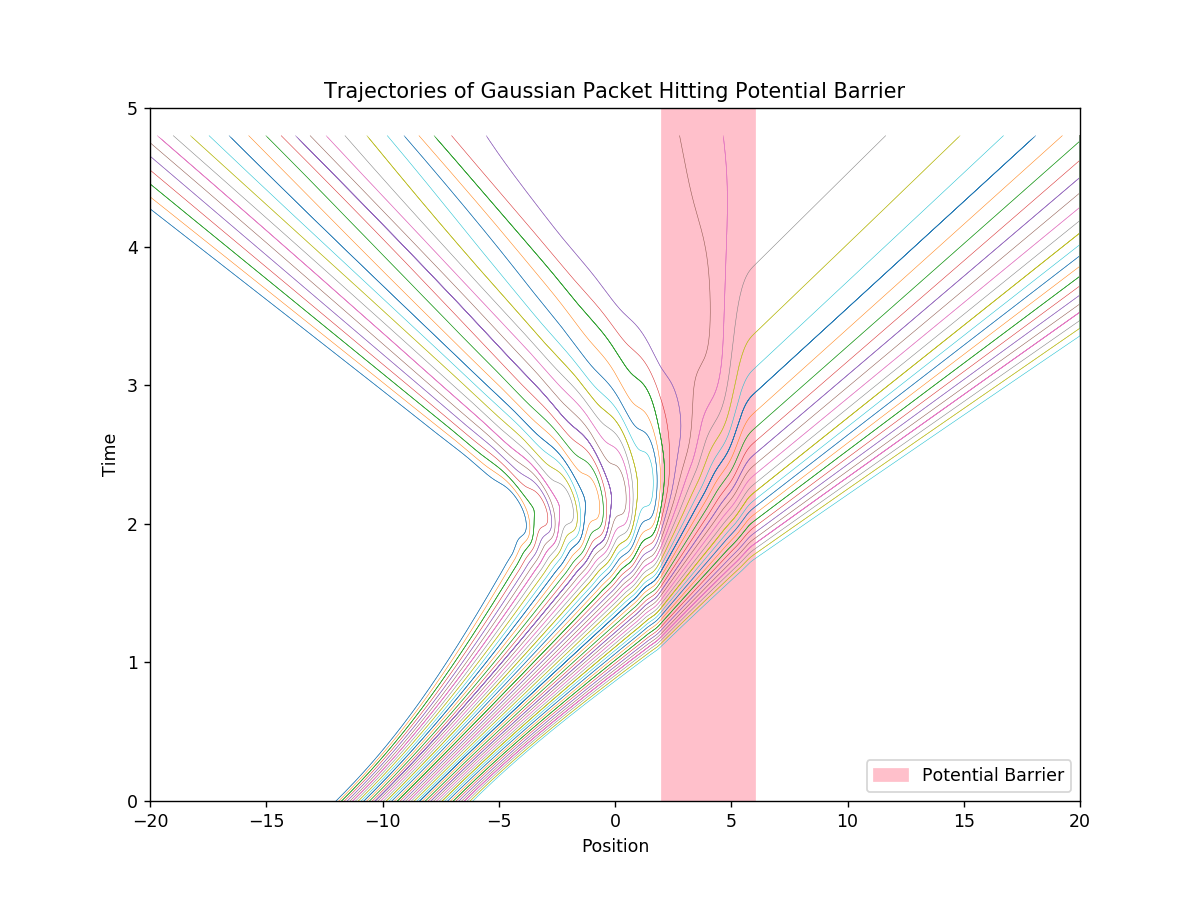

In [34]:
Tgrid = np.linspace(0, time_steps*dt, time_steps)
skip = 20

fig3, ax3= plt.subplots(figsize=(9.6, 7.2))
plt.axis([xi, xf, 0, time_steps*dt])

rect = plt.Rectangle((2,0),4,5,linewidth=1,edgecolor='pink',facecolor='pink', label='Potential Barrier')
plt.gca().add_patch(rect)

plt.xlabel('Position')
plt.ylabel('Time')
plt.title('Trajectories of Gaussian Packet Hitting Potential Barrier')
plt.legend()

def animate(i):
    for l in ax3.lines:
        l.remove()
    
    for l in range(nt//skip):
        plt.plot(x[0:i, l*skip], Tgrid[0:i], linewidth=0.3)
    
def init():
    animate(0)

init()
plt.xlim(-20, 20)
ani = animation.FuncAnimation(fig3, animate, np.arange(0, time_steps, 10), init_func=init,
                                  interval=1, blit=True)

plt.show()

ani.save('presentation/barrier-trajectories.mp4', writer=writer)

In [21]:
SaveTrajectories = False
if SaveTrajectories:
    pott = np.zeros((nt, time_steps)) #The potential will be evaluated on the trajectories
    for i in range(nt):
        for k in range(time_steps):
            pott[i, k] = V(x[i,k])

    x_pot = np.stack((x, pott))
    np.save('saves/try0', x_pot)